In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn import preprocessing
import seaborn as sns

# Spis Treści
1. [Metoda K-średnich](#kmeans)
    1. [Powtórka](#kmeans)
    2. [Mini Batch K-means](#mbkmeans)
    3. [Zadanie](#kmeans_task)
2. [DBSCAN](#DBSCAN)
    1. [Teoria](#DBSCAN)
    2. [Przykład](#DBSCAN_example)
    3. [Zadanie](#DBSCAN_task)
    4. [Źródła](#DBSCAN_sources)
3. [GMM](#GMM)
    1. [Teoria](#GMM)
    2. [Przykład](#GMM_example)
    3. [Zadanie](#GMM_task)
    4. [Źródła](#GMM_sources)
4. [Standaryzacja](#standardization)

Przygotowanie danych:

In [28]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle(for_next=True)


In [3]:
# Przygotowanie danych
n_samples = 1500
noisy_circles, _ = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs, _ = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
X, _ = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, _)

X, _ = datasets.make_blobs(n_samples=n_samples, random_state=1)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso_noisy = np.dot(X, transformation)
aniso_noisy = (X_aniso, _)

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=170)

X_batch_blobs, y_batch_blobs= datasets.make_blobs(n_samples=np.linspace(1000, 21000, 11, dtype=np.int),
                                                  random_state=8, center_box=(-100, 100),
                                                  cluster_std=np.linspace(1, 5, 11))

## Metoda K-średnich <a name="kmeans"></a>




Przypomnienie:  
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
<div align="center">Żródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68</div>

<details>
<summary>Zalety?</summary>
    
   - niska złożoność, a co za tym idzie wysoka wydajność działania,
    
   - działa szybko przy dużych zbiorach i niskich ilościach grup,
    
   - pogrupowane zbiory są z reguły bardziej ciaśniejsze i zbite.
</details>

<details>
<summary>Wady?</summary>
    
   - nie pomaga w określeniu ilości grup (K),
    
   - różne wartości początkowe prowadzą do różnych wyników,
    
   - działa dobrze tylko dla „sferycznych” skupisk o jednorodnej gęstości.
</details>

<details>
<summary>Pytania - co możemy poprawić?</summary>
    
   - Co zrobić jeśli mamy bardzo dużo danych?
   
   - Co jeśli dane nie są sferyczne?
   
   - Może automatyczna detekcja liczby skupień?
</details>

### Metoda Mini Batch <a name="mbkmeans"></a>

In [4]:
len(X_batch_blobs[:,0])

121000

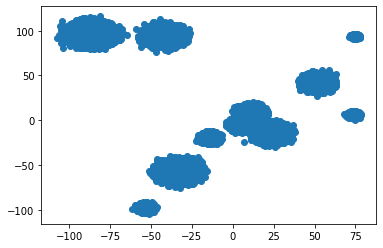

In [5]:
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

In [6]:
def _KMeans(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    return X, kmeans

def _MiniBatchKMeans(X, n_clusters):
    miniBatchKmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    miniBatchKmeans.fit(X)
    return X, miniBatchKmeans

Porównanie czasów działania:

In [7]:
%%time
kmeans=_KMeans(X_batch_blobs, n_clusters=11)

CPU times: user 9.82 s, sys: 9.39 s, total: 19.2 s
Wall time: 1.7 s


In [8]:
%%time
batch_kmeans=_MiniBatchKMeans(X_batch_blobs, n_clusters=11)

CPU times: user 328 ms, sys: 786 µs, total: 329 ms
Wall time: 328 ms


In [9]:
def plot_clusters(X, model, title="", **kwargs):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_pred, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

Wizualizacja podziału:

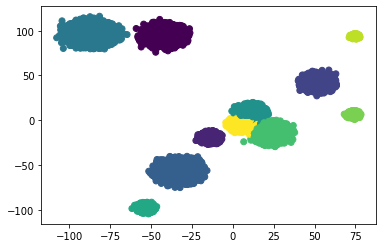

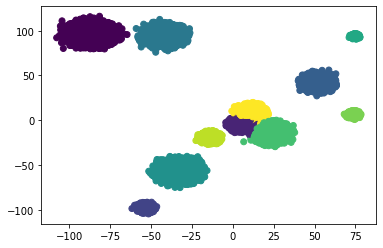

In [10]:
plot_clusters(*kmeans)
plot_clusters(*batch_kmeans)

### Zadanie * <a name="kmeans_task"></a>
Automatyczne określenie liczby skupień?


## DBSCAN  <a name="DBSCAN"></a>
### Density-based spatial clustering of applications with noise 

DBSCAN prezentuje inne podejście do problemów analizy skupień, oparte na analizie gęstości.

Dwa podstawowe parametry:
 - $\epsilon$,
 - **minPts**

Sposób działania:

   1. Znajdź punkty w sąsiedztwie ($\epsilon$) każdego punktu, znajdź "punkty bazowe" (ang. core points) mające więcej niż **minPts** sąsiadów.
   2. Znajdź spójne składowe punktów bazowych, pomijając wszystkie pozostałe punkty,
   3. Przypisz każdy pozostały punkt do najbliższego klastra, jeśli jest w jego sąsiedztwie, w przeciwnym wypadku oznacz go jako szum/obserwację odstającą.
  


<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" alt="drawing" width="400"/>

In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

Źródło ilustracji: https://en.wikipedia.org/wiki/DBSCAN

### Przykład <a name="DBSCAN_example"></a>

In [11]:
def _DBSCAN(X, eps=0.3):
    dbs = cluster.DBSCAN(eps=eps)
    dbs.fit(X)
    return X, dbs

Podstawowe parametry *sklearn.cluster.DBSCAN*: 

`eps` default=0.5  
`min_samples` default=5   
`metric` default = 'euclidean'  

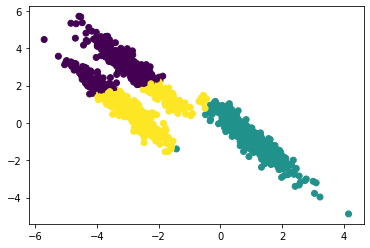

In [12]:
plot_clusters(*_KMeans(X_aniso, n_clusters=3))

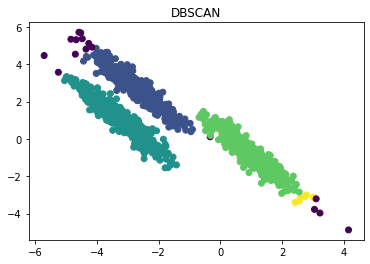

In [13]:
plot_clusters(*_DBSCAN(X_aniso), title="DBSCAN")

### Zadanie <a name="DBSCAN_task"></a>  

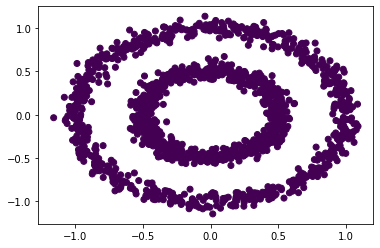

In [14]:
plot_clusters(*_DBSCAN(noisy_circles))

### Więcej <a name="DBSCAN_sources"></a>  

 - https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/DBScan_Clustering.ipynb

 - Przykład z dokumentacji: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
 
 - DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN (2017): https://dl.acm.org/doi/10.1145/3068335

## GMM (Gaussian Mixture Models) <a name="GMM"></a>

Jeszcze inne podejście oparte na modelowaniu skupień przy pomocy rozkładów normalnych.

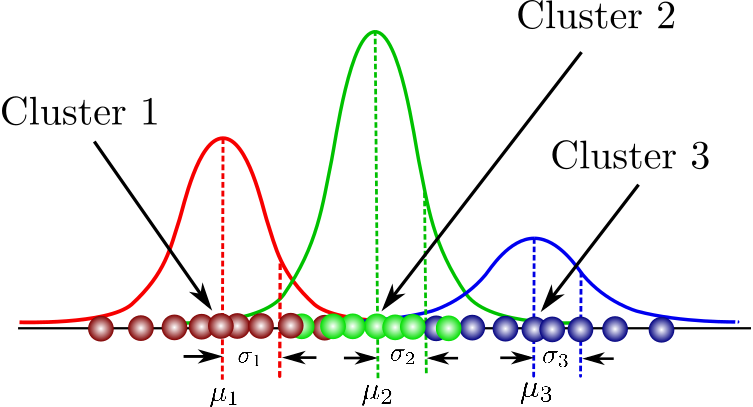

Źródło:https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

Dla **K** klastrów mamy **K** funkcji o 3 podstawowych parametrach:
 - $\mu$ - średnia określająca centrum,
 - $\Sigma$ - macierz kowariancji, określająca szerokość. W wielu wymiarach określa wymiary elipsoidy. 
 - $\pi$ - określa wysokość, $$\sum_{i}^{K}  \pi_{i} = 1$$
 
 $$p(x) = \sum_{i}^{K} \pi_{i} \mathcal{N}(\mu_{i}, \Sigma_{i})$$

W przeciwieństwie do pozostałych algorytmów zwraca prawdopodobieństwo przyporządkowania obserwacji do określonego skupienia.

Zalety:
 - rozpoznaje klastry o mniejszej gęstości,
 - rozpoznaje klastry inne niż tylko sferyczne,
 - przypadki, w których możemy wykorzystać przyporządkowanie do wielu skupień na raz.

### Przykład <a name="GMM_example"></a>

In [15]:
parameters = {
    'alpha': 0.5,
    's': 30
}

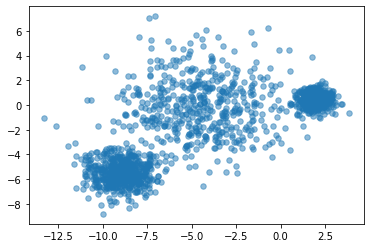

In [16]:
plt.scatter(varied[0][:,0], varied[0][:,1], **parameters)
plt.show()

Jak sobie poradzi DBSCAN?

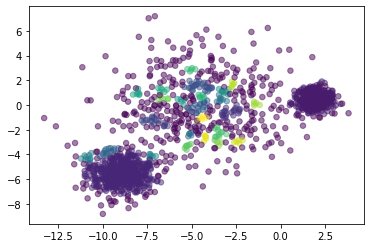

In [17]:
plot_clusters(*_DBSCAN(varied[0]), **parameters)

In [18]:
def _GMM(X, n_components, covariance_type='full'):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    return X, gmm

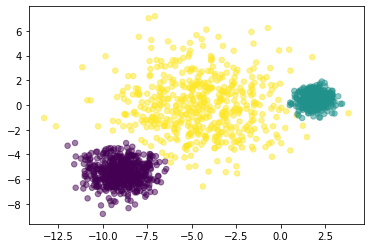

In [19]:
plot_clusters(*_GMM(varied[0], n_components=3), **parameters)

### Zadanie <a name="GMM_task"></a>
Przetestuj metody dla poniższych 3 zbiorów. Zbadaj czasy poszczególnych metod.

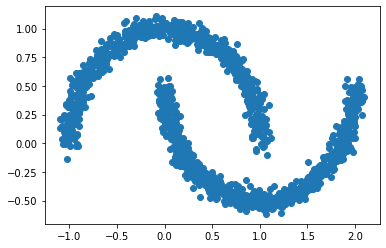

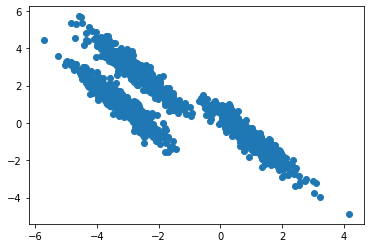

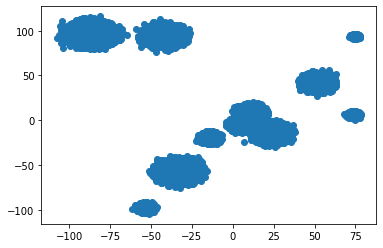

In [20]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1])
plt.show()
plt.scatter(aniso_noisy[0][:,0], aniso_noisy[0][:,1])
plt.show()
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

Więcej: <a name='GMM_sources'></a>
   - https://www.kaggle.com/sid321axn/customer-segments-gmm-vs-k-means-clustering
   - https://github.com/duducheng/clustering_tutorial/blob/master/2_Gaussian_Mixture_and_EM.ipynb

## Standaryzacja <a name="standardization"></a>

In [21]:
x1 = np.concatenate((np.random.normal(150, 5, 400), 
                     np.random.normal(100, 5, 300),
                     np.random.normal(50, 5, 300)),
                    axis=None)
x2 = np.concatenate((np.random.normal(200, 5, 400), 
                     np.random.normal(150, 5, 300),
                     np.random.normal(100, 5, 300)),
                    axis=None)
x3 = np.random.normal(10000, 1000, 1000)

df = pd.DataFrame({'X1': x1,'X2': x2,'X3': x3})
df.head()

,X1,X2,X3
0,143.050051,192.288199,10577.026701
1,157.113743,193.515275,9774.486184
2,150.589713,203.646939,12000.187307
3,148.639756,197.996825,11096.213248
4,152.521018,205.859225,10330.387585


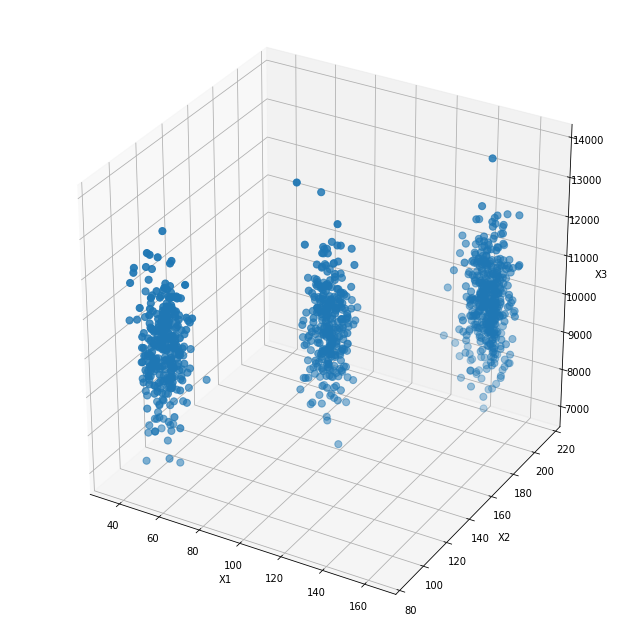

In [22]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.X1, df.X2, df.X3, s=50)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.tight_layout()
plt.show()


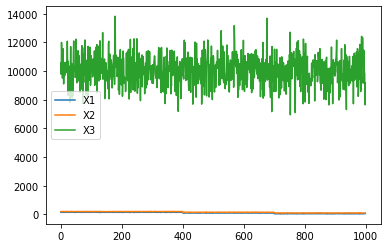

In [23]:
df.plot()

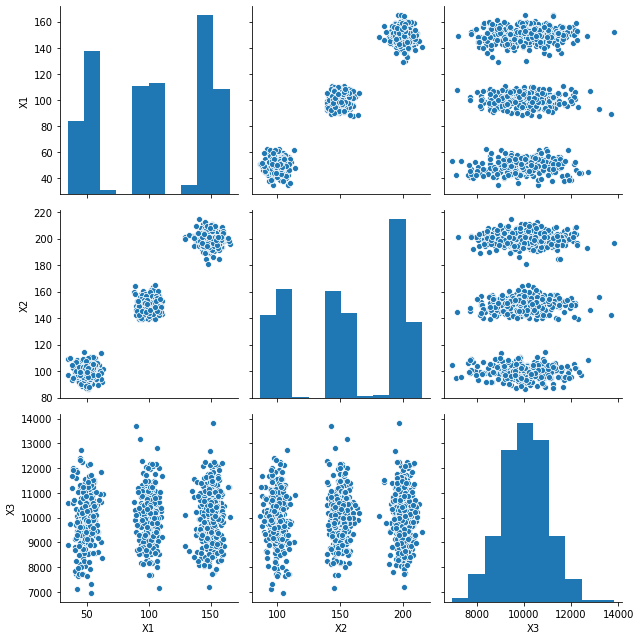

In [24]:
sns.pairplot(df, height=3)
plt.tight_layout()

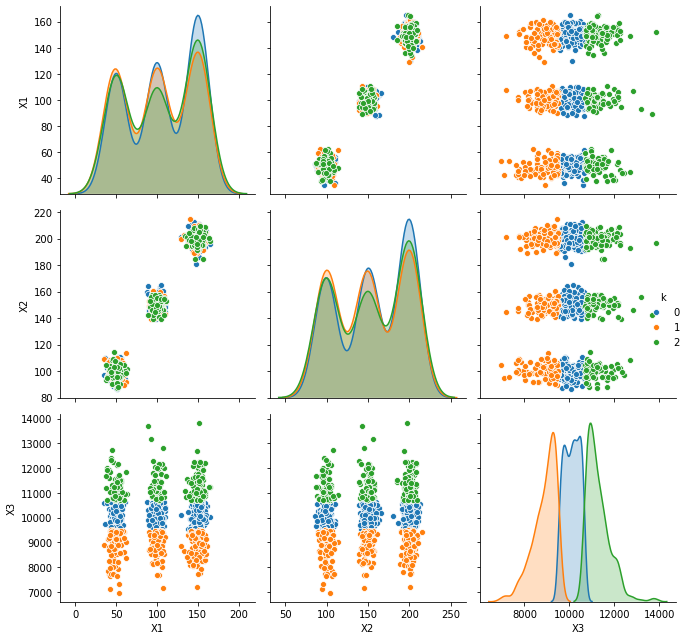

In [25]:
df['k']= hue=_KMeans(df, 3)[1].predict(df)

sns.pairplot(df, height=3, hue='k')
plt.tight_layout()

In [26]:
std_scale = preprocessing.StandardScaler().fit(df.iloc[:,[0,1,2]])
df_std = pd.DataFrame(std_scale.transform(df.iloc[:,[0,1,2]]), columns=["X1", "X2", "X3"])

df_std.head()

,X1,X2,X3
0,0.906919,0.895586,0.535432
1,1.241924,0.924946,-0.272767
2,1.086518,1.167367,1.968627
3,1.040069,1.032176,1.058279
4,1.132523,1.220300,0.287054


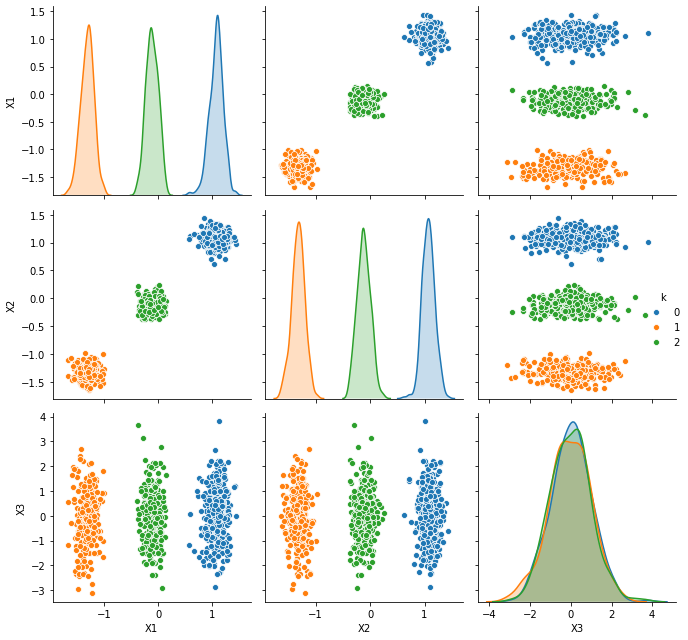

In [27]:
df_std['k']= hue=_KMeans(df_std, 3)[1].predict(df_std)

sns.pairplot(df_std, height=3, hue='k')
plt.tight_layout()

Więcej:
https://sebastianraschka.com/Articles/2014_about_feature_scaling.html